# Telco Churn

## Goal:
* Discover drivers of churn at Telco
* Use drivers to develop a machine learning model to classify customers as will churn or will not churn

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import wrangle as w
import my_model as m
import explore as e

np.random.seed(42)

## Acquire
* Data acquired from Codeup SQL server
* It contained 7043 rows and 24 columns before cleaning
* Each row represents data from a single customer at Telco
* Each column represents a feature of that customer

## Prepare
* Removed columns that did not contain useful information
* Checked for nulls in the data
    * total_charges had empty strings for brand new customers
    * changed those empty strings to '0.00'
* Checked that column data types were appropriate (e.g. changed total_charges from string to float)
* Encoded categorical variables
* Split data into train, validate, and test (~ 60/20/20), stratifying on 'churn'
* Outliers have not been removed

## Data Dictionary

| Feature | Type | Definition |
|:--------|:-----|:-----------|
|customer_id|string|unique identifer for each customer; format 1111-AAAAA|
|gender|string|Male or Female|
|senior_citizen|integer|1 for IS a senior citizen, 0 if not|
|partner|string|Yes if customer has a partner, No if not|
|dependents|string|Yes if customer has dependents, No if not|
|tenure|integer|number of months customer has been with Telco|
|phone_service|string|Yes if customer has phone service, No if not|
|multiple_lines|string|Yes, No, or No Phone Service|
|internet_service_type|string|Fiber optic, DSL, or None|
|online_security|string|Yes, No, or No internet service|
|online_backup|string|Yes, No, or No internet service|
|device_protection|string|Yes, No, or No internet service|
|tech_support|string|Yes, No, or No internet service|
|streaming_tv|string|Yes, No, or No internet service|
|streaming_movies|string|Yes, No, or No internet service|
|contract_type|string|Month-to-Month, One year, Two year|
|paperless_billing|string|Yes if they have paperless billing, No if not|
|payment_type|string|Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)|
|monthly_charges|float|This is the customer's monthly bill|
|total_charges|float|This is the total amount a customer has paid since being with the company|
|churn|string|Yes if customer churned, No if they stayed with company|

In [2]:
# acquiring and preparing the data for exploration
df = w.get_telco_data()
e_df = w.prep_telco_to_explore(df)

# splitting data into train, validate, and test
target = 'churn'
train, validate, test = w.split_function(e_df, target)

# get non-encoded columns to make it easier to look at
ne_train = e.get_telco_ne_df(train)

csv file found and read
Prepared df: (7043, 48)

Train: (4225, 48)
Validate: (1409, 48)
Test: (1409, 48)


### A brief look at the data

In [3]:
ne_train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_type,monthly_charges,total_charges,churn
2332,3338-CVVEH,Male,0,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,94.55,1173.55,No
5275,7442-YGZFK,Male,0,No,No,1,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),49.80,49.80,No
6429,9102-OXKFY,Male,0,No,No,59,Yes,Yes,DSL,No,...,Yes,No,No,No,Two year,No,Credit card (automatic),54.15,3116.15,No
89,0141-YEAYS,Female,1,No,No,27,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),86.45,2401.05,No
6412,9079-YEXQJ,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,No,Electronic check,111.10,6014.85,Yes


### A summary of the data

In [4]:
ne_train.describe()

,senior_citizen,tenure,monthly_charges,total_charges
count,4225.000000,4225.000000,4225.000000,4225.000000
mean,0.159053,32.562367,65.273243,2320.103183
std,0.365769,24.755164,30.218179,2297.297588
min,0.000000,0.000000,18.400000,0.000000
25%,0.000000,9.000000,36.450000,392.650000
50%,0.000000,29.000000,70.750000,1414.800000
75%,0.000000,56.000000,90.350000,3902.450000
max,1.000000,72.000000,118.750000,8684.800000


## Explore

### How often does churn occur?

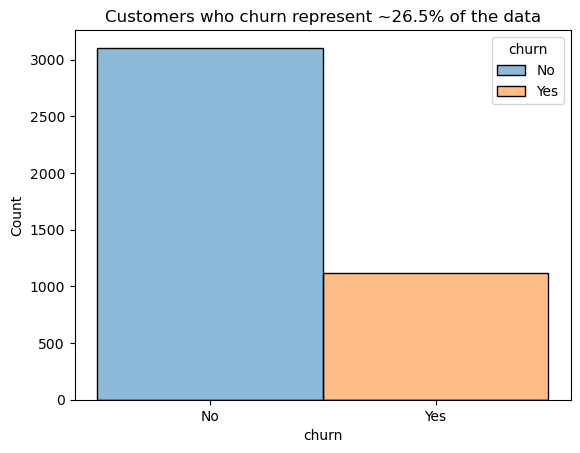

In [5]:
# get a histogram of churn
e.get_hist_churn(ne_train)

* Customers who churn represent ~ 26.5% of the data

## Do monthly_charges affect churn?

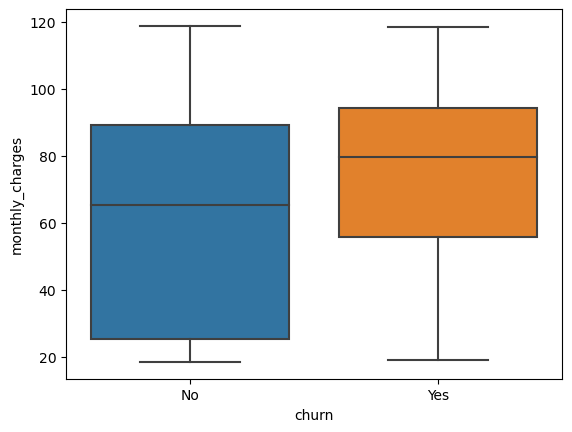

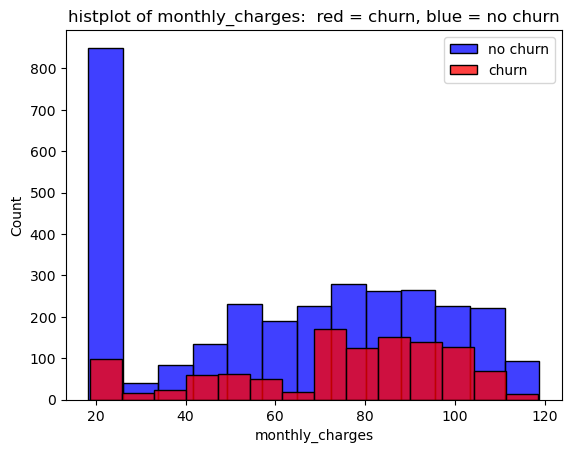

In [6]:
# get boxplot and histplot for monthly_charges vs churn 
e.get_box_plot(ne_train, feature='monthly_charges')
e.get_hist_plot(ne_train, feature='monthly_charges')

### Analyze monthly_charges vs churn with statistics
- $H_0$ There is NO relationship between monthly charges and churn
- $H_a$ There IS a relationship
- $\alpha$ = .05
- categorical vs continuous variables not normally distributed => mannwhitneyu test

In [7]:
# get mannwhitneyu test
e.get_mannwhitneyu(ne_train)

t = 1351248.0
p = 1.261599899747347e-28


- p is < $\alpha$, so we can reject the $H_0$ which suggests the $H_a$

- when monthly_charges are < \\$30;  10.4\% of people churned (101/975)

- when monthly_charges are >= \\$30; 31.4% of people churned (1020/3250)

- when monthly_charges are between \\$70 - \\$110; 36% of people churned (736/2037)


- If our model simply predicted churn when monthly_charges >= 30, a confusion matrix would look like this:

|               | pred_No_churn | pred_Yes_churn |
|:--------------|:-------------:|:--------------:|
|actual_No_churn|874|2230|
|actual_Yes_churn|101|1020|

- accuracy is only 45%, but recall is 91%


- In summary, higher monthly charges increases the likelihood of churn.

## Does tenure affect churn?

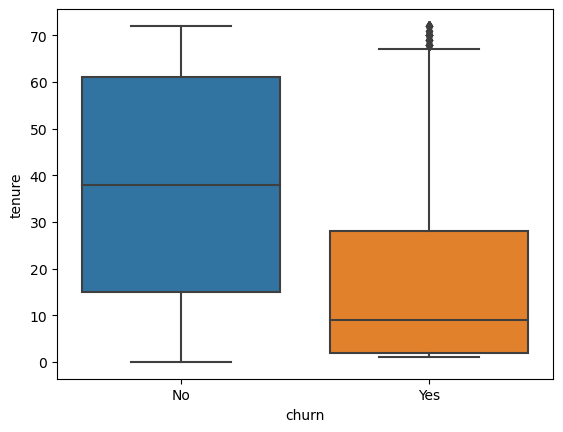

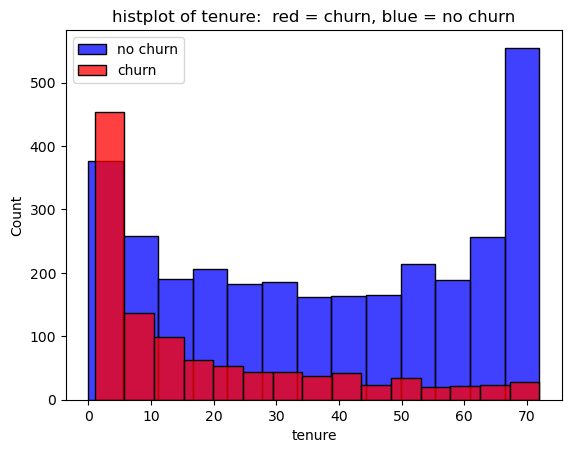

In [8]:
# get boxplot for tenure vs churn
e.get_box_plot(ne_train, feature='tenure')
e.get_hist_plot(ne_train, feature='tenure')

### Analyze tenure vs churn with statistics
- $H_0$ There is NO relationship between tenure and churn
- $H_a$ There IS a relationship
- $\alpha$ = .05
- categorical vs continuous variables not normally distributed => mannwhitneyu test

In [9]:
# get mannwhitneyu test
e.get_mannwhitneyu(ne_train, feature='tenure')

t = 2590959.0
p = 9.793028571741095e-131


- p is < $\alpha$, so we can reject the $H_0$ which suggests the $H_a$

- when tenure is <= 10/15/20 months, 50/46/44 % of people churned

- in contrast, when tenure is > 20 months, only 14% of people churned

- If our model simply predicted churn when tenure <= 20 months, a confusion matrix would look like this:

|               | pred_No_churn | pred_Yes_churn |
|:--------------|:-------------:|:--------------:|
|actual_No_churn|2142|962|
|actual_Yes_churn|359|762|

- accuracy is only 69%, but recall is 68%

- In summary, lower tenure increases the likelihood of churn.

## Does contract_type affect churn?

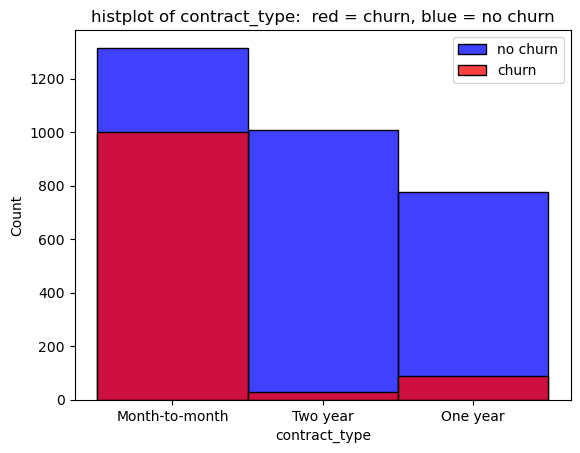

In [10]:
# get histplot for contract_type vs churn
e.get_hist_plot(ne_train, feature='contract_type')

### Analyze contract_type vs churn with statistics
- $H_0$ There is NO relationship between contract_type and churn
- $H_a$ There IS a relationship
- $\alpha$ = .05
- categorical vs categorical variables => chi^2 test

In [11]:
# get chi-square results
e.get_chi_results(ne_train, feature='contract_type')

chi^2 = 748.2006336217892
p     = 3.3907574978861363e-163


- p is < $\alpha$, so we can reject the $H_0$ which suggests the $H_a$

- In summary, a contract_type of Month-to-month increases the likelihood of churn.

## Does payment_type affect churn?

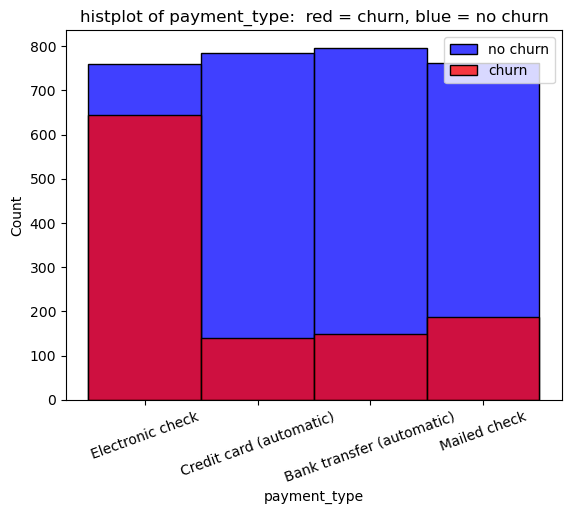

In [12]:
# get histplot for payment_type vs churn
e.get_hist_plot(ne_train, feature='payment_type')

### Analyze payment_type vs churn with statistics
- $H_0$ There is NO relationship between payment_type and churn
- $H_a$ There IS a relationship
- $\alpha$ = .05
- categorical vs categorical variables => chi^2 test

In [13]:
# get chi-square results
e.get_chi_results(ne_train, feature='payment_type')

chi^2 = 411.5935596871652
p     = 6.820556365758793e-89


- p is < $\alpha$, so we can reject the $H_0$ which suggests the $H_a$

- In summary, a payment_type of Electronic check increases the likelihood of churn.

## Exploration Summary
* Drivers of churn: monthly_charges, tenure, contract_type, and payment_type
* \*Additional drivers of churn: paperless_billing, internet_service_type, online_security, online_backup, device_protection, and tech_support

* Non-significant drivers of churn: multiple_lines, phone_service, streaming_tv, streaming_movies
* Repeated information: total_charges (directly related to tenure)

\* Visualizations and stats test for additional drivers of churn not shown in this workbook

## Features I am moving to modeling with
* monthly_charges
* tenure
* contract_type
* payment_type
* internet_service_type
* tech_support
* paperless_billing
* online_security
* online_backup
* device_protection


## Features I am NOT moving to modeling with
* multiple_lines
* phone_service
* streaming_tv
* streaming_movies
* total_charges
* gender
* senior_citizen
* partner
* dependents

## Modeling
* I will use accuracy and recall (TP/(TP+FN)) as my evaluation metrics 
    * Priority 1: accuracy
    * Priority 2: recall
* Customers who did NOT churn represent 73.5% of the data
* By guessing NOT churn for every customer, one could achieve an accuracy of 73.5%. Therefore 73.5% will be the baseline accuracy I use for this project
* I will be evaluating models developed using four different model types and various hyperparameter configurations 
    * The four model types are Logistic Regression, knn, Random Forest, and Decision Tree
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data

In [14]:
# reset target, prep data for modeling
target = 'churn_encoded'
X_train, X_validate, X_test, y_train, y_validate, y_test, baseline = m.model_prep(train, validate, test, target)
print(f'baseline accuracy = {round(baseline,3)}')

baseline accuracy = 0.735


### Top 3 Models
* 1. DecisionTree(max_depth=6) with features2: 
* 2. knn(n_neighbors=14) with features1: 
* 3. LogisticRegression(C=1) with features1: 

features1 = 

    - monthly_charges, 
    - tenure, 
    - contract_type, 
    - payment_type, 
    - internet_service_type, 
    - tech_support
    - paperless_billing, 
    - online_security, 
    - online_backup, 
    - device_protection, 


features2 = 

    - monthly_charges, 
    - tenure, 
    - contract_type, 
    - payment_type, 
    - internet_service_type, 
    - tech_support

i.e. features2 = features1 - paperless_billing, online_security, online_backup, device_protection

### Decision Tree with features2

In [15]:
# get Decision Tree (max_depth=6) results
m.get_tree_features2(X_train, X_validate, y_train, y_validate)

Accuracy on train is 0.8170414201183432
Recall on train is 0.5227475468331847

Accuracy on validate is 0.78708303761533
Recall on validate is 0.4919786096256685


* Decision Tree with features2 beats baseline of .735

### knn with features1

In [16]:
# get knn (n_neighbors=14) results
m.get_knn_all_features(X_train, X_validate, y_train, y_validate)

Accuracy on train is 0.8149112426035503
Recall on train is 0.5022301516503123

Accuracy on validate is 0.78708303761533
Recall on validate is 0.45989304812834225


* knn with all features beats baseline of .735

### Logistic Regression with features1

In [17]:
# get Logistic Regression (C=1) results
m.get_reg_all_features(X_train, X_validate, y_train, y_validate)

Accuracy on train is 0.8087573964497041
Recall on train is 0.552185548617306

Accuracy on validate is 0.7849538679914834
Recall on validate is 0.5213903743315508


* Logistic Regression with all features beats baseline of .735

## Comparing Models

* The best models of the eight assessed (four types * 2 sets of features)
* 1. DecisionTree(max_depth=6) with features2: train/val accuracy = .817/.787; Recall = .52/.49
* 2. knn(n_neighbors=14) with features1: train/val accuracy = .815/.787; Recall = .50/.46
* 3. LogisticRegression(C=1) with features1: train/val accuracy = .809/.785; Recall = .55/.52


- All three models beat the baseline (.735). 
- All three models are very similar, and I could move forward with any of them.
- I have chosen to move forward with the Decision Tree model

### Decision Tree on test

In [18]:
# get test results for final model
m.get_tree_features2(X_train, X_test, y_train, y_test)

Accuracy on train is 0.8170414201183432
Recall on train is 0.5227475468331847

Accuracy on validate is 0.7814052519517388
Recall on validate is 0.4786096256684492


### Modeling Summary

- When evaluated on unseen data, the selected Decision Tree model had an accuracy of .781 and a recall of .478
- This model does beat the baseline of .735, but it's recall indicates we will miss ~50% of customers who churn


# Conclusions
## Exploration
- customers choose to churn ~26.5% of the time in the dataset
- customers with higher monthly charges churn more often
    - monthly_charges >=30   => 31% churn rate
    - monthly_charges 70 - 110  => 36% churn ratee
    - in contrast, when monthly_charges < 30   => 10% churn rate
- customers with lower tenure churn more often
    - when tenure is <= 10/15/20 months, 50/46/44 % of people churned
    - in contrast, when tenure is > 20 months, only 14% of people churned
- other drivers of increased churn rate:
    - contract_type == Month-to-month
    - payment_type == Electronic check
    - internet_service_type == Fiber optic
    - paperless_billing == Yes
    - online_security/online_backup/device_protection/tech_support == No

    

## Modeling

- The final model outperformed the baseline by a small margin (78% vs 73.5%) 
- However, the recall was only 48% on unseen data which means this model would miss 52% of customers who churn
- A very simple model that targeted customers with monthly_charges >= 30 would only be ~45% accurate, but it would capture ~91% of customers who are about to churn
- Another very simple model that targeted customers whose tenure is <= 20 would be ~68% accurate and capture ~69% of customers about to churn

# Recommendations
- Consider offering a year-long contract at a reduced rate for customers predicted to churn by the model
- Considering a variety of customer engagement strategies:
    - when the cost of engagement is low, utilize a simple model (monthly_charges >= 30 or tenure <= 20) to reach the max percentage of customers about to churn
    - when the cost of engagement is higher, consider the Decision Tree model since it's accuracy is higher, i.e. less likely to engage with customers who already do not plan to churn
- Consider collecting additional data to model. For example:
    - region and/or zip code,
    - number of customer service interactions (phone calls, service appointments), 
    - number of close contacts with Telco 

## Next steps
- With more time, I would run the various models on different sets of features. 
    - For instance: only use monthly_charges and tenure
    - OR since online_security/online_backup/device_protection/tech_support have very similar percentages, I would check to see if these are generally the same customers, and if so, pick just one and exclude the rest
- With more time, I would investigate other sklearn models and other methodologies that may work better.
- I excluded the demographics variables very quickly (gender, partner, dependents, senior_citizen) so I would look at them more closely

In [19]:
# writing prediction.csv with best model
m.get_write_predictions_csv(X_train, X_test, y_train, test.customer_id)

csv file found and overwritten


In [20]:
%%html 
<style>
  table {margin-left: 0 !important;}
</style>